In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
gdf = pd.read_parquet("../data/processed/eda2.parquet")

In [103]:
threshold = 5000

(gdf["price"]>threshold).sum()/len(gdf)

0.13156416736871665

In [104]:
gdf = gdf[gdf["price"]<threshold]

In [105]:
# Quick patch for letType and furnishType

gdf["letType"] = gdf["letType"].fillna("not_specified")
gdf["furnishType"] = gdf["furnishType"].fillna("uknown")

### Split dataset geographicaly 

In [106]:
seed = 42 # Fix seed for reproducibility of the splt

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in stratified_split.split(gdf, gdf['borough']):
    train_df = gdf.iloc[train_index]
    test_df = gdf.iloc[test_index]

In [107]:
embeds_train = []
embeds_test = []

for row in train_df["embeddings"]:
    embeds_train.append(row)
    
for row in test_df["embeddings"]:
    embeds_test.append(row) 
    
    
Xe_train = np.array(embeds_train)
Xe_test = np.array(embeds_test)

In [117]:
from scipy.stats import boxcox
from sklearn.neural_network import MLPRegressor
model = MLPRegressor([512,256,128],learning_rate_init=0.01)

# Apply Box-Cox transformation and store lambda
y_train_tr, lambda_ = boxcox(train_df["price"].values)  # Now we have lambda_
y_train_tr /= 2  # Scale the transformed target


In [118]:
model.fit(Xe_train, y_train_tr)

MLPRegressor(hidden_layer_sizes=[512, 256, 128], learning_rate_init=0.01)

In [121]:
from scipy.special import inv_boxcox

# Predict transformed values
y_pred_transformed = model.predict(Xe_test)

# Undo the division by 2
y_pred_transformed *= 2

# Apply inverse Box-Cox transformation
y_pred_original = inv_boxcox(y_pred_transformed, lambda_)


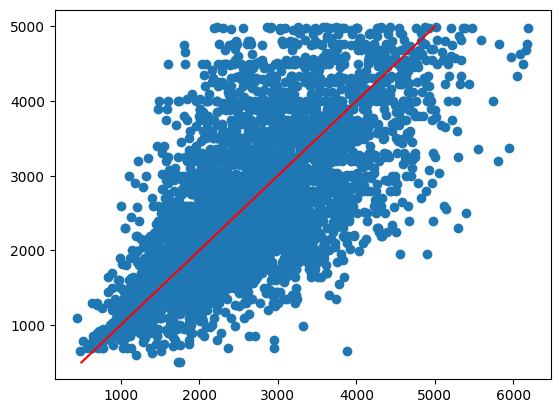

In [122]:
plt.scatter(y_pred_original,test_df["price"])
plt.plot(np.linspace(500,5000,10),np.linspace(500,5000,10),c="red",label="perfect")

In [123]:
y_true = test_df["price"]
y_pred = y_pred_original

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 23.20%
MAE: 556.37
R²: 0.39


In [102]:
y_true = test_df["price"]
y_pred = y_pred_original

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 26.94%
MAE: 838.82
R²: 0.49


In [95]:
y_true = test_df["price"]
y_pred = y_pred_original

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 23.85%
MAE: 812.98
R²: 0.48


In [46]:
y_test_pred = model.predict(Xe_test)

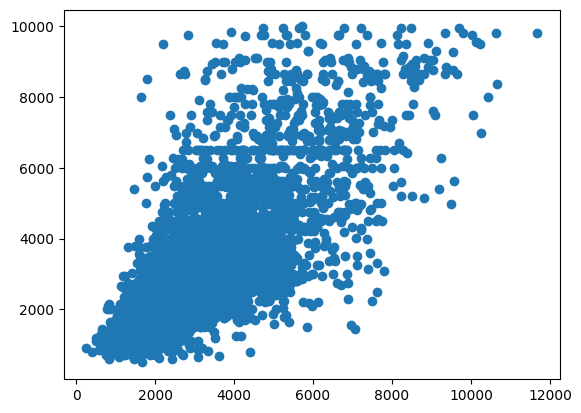

In [32]:
plt.scatter(y_test_pred,test_df["price"])

In [19]:
y_true = test_df["price"]
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 28.77%
MAE: 821.29
R²: 0.56


In [33]:
y_true = test_df["price"]
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 28.86%
MAE: 829.30
R²: 0.54


In [28]:
y_true = test_df["price"]
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 30.47%
MAE: 860.87
R²: 0.52


In [21]:
print(y_true)

10190    1200
7038     4225
21526    6500
13061    2816
10050    2150
         ... 
29479    2000
19476    2200
17853    1800
21192    3800
22256    1950
Name: price, Length: 5698, dtype: int64


In [22]:
print(y_pred)

[2653.45920677 4175.47202177 5569.92510219 ... 1527.51399769 3103.69555358
 2184.35145321]


### Train Model

In [9]:
numerical_features = ["latitude", "longitude","distance_to_center","angle_from_center","distance_to_station1","distance_to_station2","distance_to_station3"]
categorical_features = ["bedrooms","bathrooms","deposit","zone","borough","propertyType","furnishType","NoiseClass","letType", "TFL1", "TFL2", "TFL3", "RAIL1", "RAIL2","RAIL3"]
 
features = numerical_features+categorical_features
target = "price"


model = CatBoostRegressor(cat_features=categorical_features)
model.fit(train_df[features],train_df[target])

Learning rate set to 0.067097
0:	learn: 1701.1794427	total: 68.9ms	remaining: 1m 8s
1:	learn: 1636.2356389	total: 87.3ms	remaining: 43.6s
2:	learn: 1576.5087021	total: 98.5ms	remaining: 32.7s
3:	learn: 1523.7128639	total: 108ms	remaining: 26.8s
4:	learn: 1473.7194283	total: 114ms	remaining: 22.6s
5:	learn: 1428.8259223	total: 117ms	remaining: 19.3s
6:	learn: 1388.0219177	total: 120ms	remaining: 17.1s
7:	learn: 1351.3150172	total: 124ms	remaining: 15.4s
8:	learn: 1315.8272519	total: 127ms	remaining: 14s
9:	learn: 1284.2801912	total: 130ms	remaining: 12.9s
10:	learn: 1253.9195245	total: 133ms	remaining: 12s
11:	learn: 1227.1969954	total: 137ms	remaining: 11.3s
12:	learn: 1202.7799369	total: 140ms	remaining: 10.6s
13:	learn: 1180.4560814	total: 143ms	remaining: 10.1s
14:	learn: 1161.2878080	total: 146ms	remaining: 9.6s
15:	learn: 1143.5769210	total: 150ms	remaining: 9.24s
16:	learn: 1126.3894280	total: 154ms	remaining: 8.88s
17:	learn: 1110.4366478	total: 156ms	remaining: 8.54s
18:	learn:

### Calculate errors in predictions 

In [10]:
y_test_pred = model.predict(test_df[features])

y_true = test_df[target].values
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 14.91%
MAE: 468.47
R²: 0.83


Text(0, 0.5, 'Predicted')

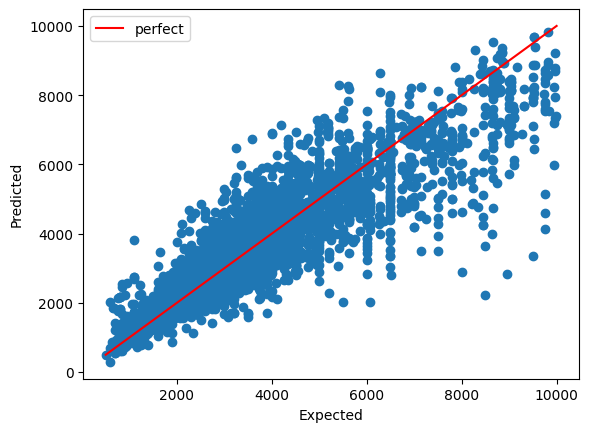

In [11]:
plt.scatter(test_df[target].values,y_test_pred)
plt.plot(np.linspace(500,10000,10),np.linspace(500,10000,10),c="red",label="perfect")
plt.legend()
plt.xlabel("Expected")
plt.ylabel("Predicted")

The model is biased for super expensive properties

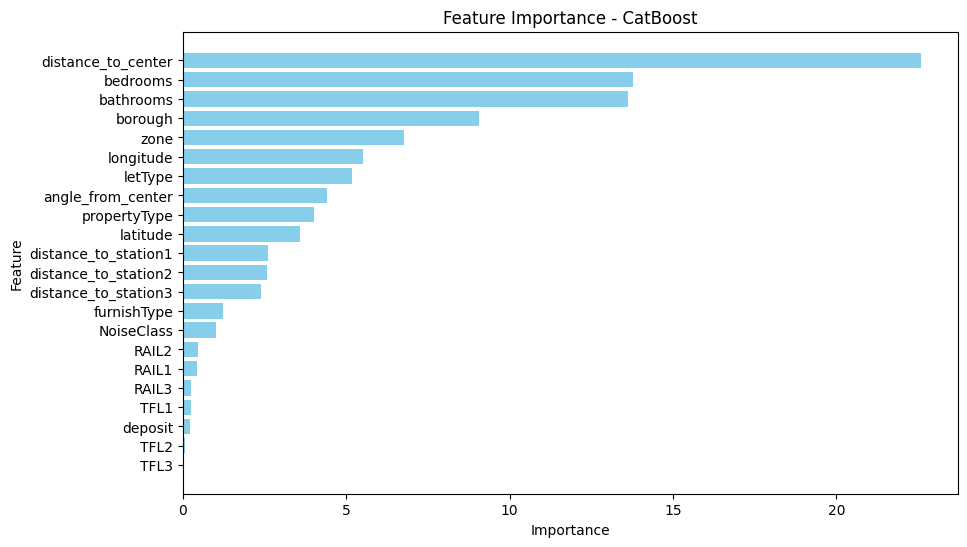

In [12]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.gca().invert_yaxis()  
plt.show()